In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 16 11:05:15 2022

@author: wzx
"""
from cmath import inf
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import random
from imblearn.over_sampling import SMOTE
plt.style.use('default')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sampler import BalancedBatchSampler
from torch.autograd import Variable
from torchvision import transforms as T
from matplotlib import rcParams
from sklearn.manifold import TSNE
from tqdm import tqdm
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from imblearn.metrics import geometric_mean_score
import pickle
import pandas as pd
from tqdm import trange

gpu_device = torch.device('cuda')
cpu_device = torch.device('cpu')

params = {'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'font.style': 'italic',
          'font.weight': 'normal',  # or 'blod'
          'font.size': '14',  # or large,small
          }
rcParams.update(params)
font = {'family': 'serif',
        'style': 'italic',
        'color': 'white',
        'weight': 'normal',
        }

# X_train = np.load('X_train_' + 'sup'+ '.npy')  # npy文件是已经构建好的不平衡数据集，.npy格式
# y_train = np.load('y_train_' + 'sup'+ '.npy')
# X_test = np.load('X_test_' + 'sup'+ '.npy')
# y_test = np.load('y_test_' + 'sup'+ '.npy')


X_train = np.load('X_train_' + 'num15sup'+ '.npy')  # 15号机组监督方法所用数据集
y_train = np.load('y_train_' + 'num15sup'+ '.npy')
X_test = np.load('X_test_' + 'num15sup'+ '.npy')
y_test = np.load('y_test_' + 'num15sup'+ '.npy')

# X_train = np.load('X_train_' + 'num21sup'+ '.npy')  # 21号机组监督方法所用数据集
# y_train = np.load('y_train_' + 'num21sup'+ '.npy')
# X_test = np.load('X_test_' + 'num21sup'+ '.npy')
# y_test = np.load('y_test_' + 'num21sup'+ '.npy')

# X_train = np.load('X_train_' + 'num21sup'+ '.npy')  # 21号机组监督方法所用数据集
# y_train = np.load('y_train_' + 'num21sup'+ '.npy')
# X_test = np.load('X_test_' + 'num21sup'+ '.npy')
# y_test = np.load('y_test_' + 'num21sup'+ '.npy')

print('train:', len(X_train))
print('test:', len(X_test))

train: 26196
test: 11227


### SMOTE

In [2]:
sm = SMOTE(sampling_strategy=0.15, random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)

normal = []
fault = []
for i in range(len(X_train)):
    if y_train[i] == 0:
        normal.append(X_train[i])
    else:
        fault.append(X_train[i])

print('after oversampling, fault:', len(fault))
# fault
print('after oversampling, ratio of fault =', len(fault) / (len(normal) + len(fault)))

# X_train = np.array(np.concatenate((normal, fault), axis=0))
# y_train = np.array([0 for i in range(len(normal))] + [1 for i in range(len(fault))])

# print('X_train:', X_train.shape)
assert len(X_train) == len(y_train)

after oversampling, fault: 3672
after oversampling, ratio of fault = 0.130420884389984


### ResNet

In [3]:
#!/usr/bin/python
# -*- coding:utf-8 -*-
from torch import nn
import warnings


# -----------------------input size>=32---------------------------------
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x1(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x1(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.downsample = downsample #对输入特征图大小进行减半处理
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = conv3x1(planes, planes, stride)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm1d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, in_channel=1, out_channel=10, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channel, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512 * block.expansion, out_channel)

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm1d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model


### 数据批次处理

In [4]:
class MyDataset(Dataset):  # 把数据变成批次加载数据 然后做变换transform
    def __init__(self, x_dir, y_dir, transform=None):
        self.X = x_dir
        self.X = torch.from_numpy(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = y_dir
        self.y = torch.from_numpy(self.y)
        self.y = torch.tensor(self.y, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.X[idx]
        label = self.y[idx]
        if self.transform:
            x = self.transform(x)
#         print(x.shape)
        x = x.unsqueeze(0)#把x在第0维加一个维度，x变成一个1*26的矩阵,DNN不用，CNN、ResNet、LSTM需要这一步
#         print(x.shape)
        return x, label


### 图像绘制

In [5]:
def plot_fig(x, y, xlabel, ylabel, legend, title, savename):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend)
    plt.title(title)
#     plt.savefig(savename, dpi=600)


### 训练模型

In [17]:
def train(train_loader, test_loader, net):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    epochs = 5
    t = trange(epochs)
    losses = []
    accList = []
    best_acc = 0
    best_epoch = 0
    for epoch in t:
        runningloss = 0
        for idx, (imgs, label) in enumerate(train_loader):
            imgs = imgs.to(device)
            label = label.to(device)
            out = net(imgs)
            optimizer.zero_grad()
            loss = criterion(out, label)
            loss.backward()
            optimizer.step()
            
            runningloss += loss.item() / imgs.shape[0]
        losses.append(runningloss)
        
        net.eval()
        total_correct = 0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                output = net(images)
                _, pred = torch.max(output, 1)

                total_correct += torch.sum(pred == labels).item()
        accuracy = total_correct / len(testloader.dataset)  # 保存每个epoch的accuracy
        accList.append(accuracy)
        t.set_postfix(loss="{:05.4f}".format(runningloss), acc="{:05.04f}".format(accuracy))
        # print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch+1, epochs, runningloss, accuracy))#在python中,“\t”是指制表符,代表着四个空格,也就是一个tab
        if best_acc < accuracy:
            best_acc = accuracy
            best_epoch = epoch

    best_loss = min(losses)
    print('best_acc:{}, best_epoch:{}'.format(best_acc, best_epoch))

    plot_fig(range(len(losses)), losses, 'Epoch', 'Loss', [], 'loss', '')
    
    plot_fig(range(len(accList)), accList, 'Epoch', 'Acc', [], 'Acc', '')

### 绘制混淆矩阵

In [18]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    print('df_confusion:\n', df_confusion)
    plt.matshow(df_confusion, cmap=cmap)  # imshow
    print('df_confusion.shape:{}'.format(df_confusion.shape))

    tick_marks = np.arange(len(df_confusion.columns))

    for i in range(df_confusion.shape[0]):
        for j in range(df_confusion.shape[1]):
            if i == j:
                plt.text(i, j, str('%.1f' % (df_confusion[i][j] * 100)), va='center', ha='center', fontdict=font,
                         fontsize=8)
            else:
                plt.text(i, j, str('%.1f' % (df_confusion[i][j] * 100)), va='center', ha='center', fontsize=8)

    # plt.tight_layout()

    plt.xticks(tick_marks, ['0', 'Fault'], rotation=45)
    plt.yticks(tick_marks, ['0', 'Fault'])
    plt.ylim(1.5, -0.5)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.title(title)
    plt.colorbar()
    



C:\Users\Zixuan Wang\AppData\Local\Temp\ipykernel_39696\760258945.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(self.X, dtype=torch.float32)
C:\Users\Zixuan Wang\AppData\Local\Temp\ipykernel_39696\760258945.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(self.y, dtype=torch.long)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.22s/it, acc=0.9711, loss=0.1512]


best_acc:0.9740803420326, best_epoch:3
                   pre       rec       spe        f1       geo       iba       sup

          0     0.9860    0.9832    0.7857    0.9846    0.8789    0.7878     10541
          1     0.7528    0.7857    0.9832    0.7689    0.8789    0.7573       686

avg / total     0.9718    0.9711    0.7978    0.9714    0.8789    0.7859     11227

df_confusion:
 Predicted Fault Mode IDs         0         1
Actual Fault Mode IDs                       
0                         0.983208  0.016792
1                         0.214286  0.785714
df_confusion.shape:(2, 2)


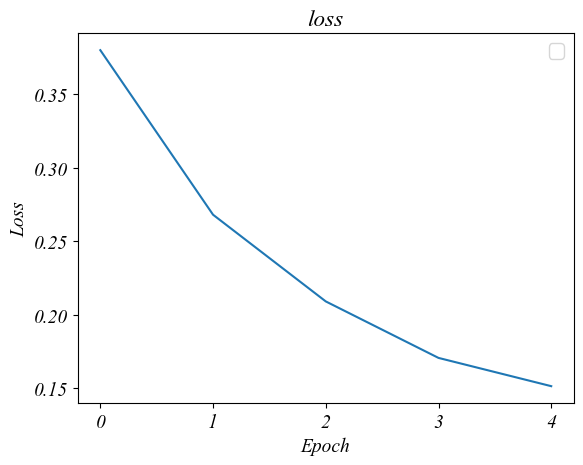

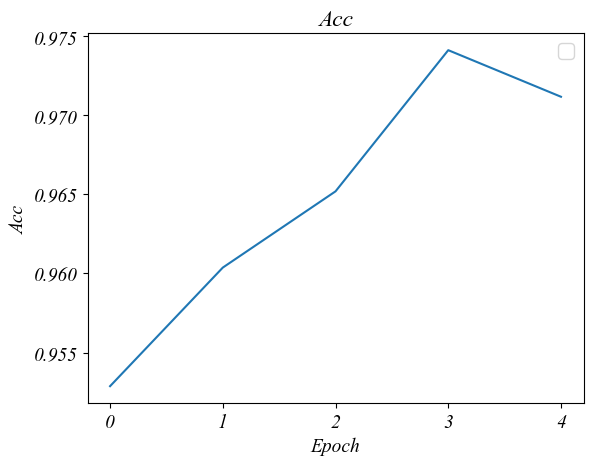

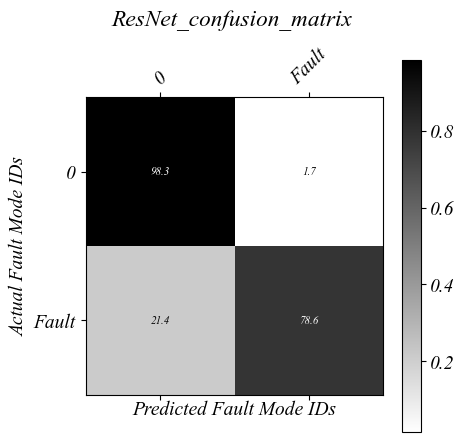

In [19]:
if __name__ == "__main__":
    num_workers = 0
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
#     print('X_train形状：', X_train.shape)
#     print('X_train第一行：', X_train[0])
    data_train = MyDataset(X_train, y_train)
    data_test = MyDataset(X_test, y_test)
#     print('处理后data_train类型：',data_train[0])
    
    
    trainloader = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(dataset=data_test, batch_size=128, shuffle=True, num_workers=num_workers)
    
    net = resnet50().to(device)
    
    train(trainloader, testloader, net)
    y_true = []
    y_pred = []
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            for i in labels:
                y_true.append(i.item())
            images = images.to(device)
            labels = labels.to(device)
            output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            for i in pred:
                y_pred.append(i.item())
            total_correct += torch.sum(pred == labels).item()

    accuracy = total_correct / len(testloader.dataset)
    classification_report = classification_report_imbalanced(y_true, y_pred, target_names=None, digits=4)
    sensitivity = sensitivity_score(y_true, y_pred, average=None)
    specificity = specificity_score(y_true, y_pred, average=None)
    geometric_mean = geometric_mean_score(y_true, y_pred, average=None)

    print(classification_report)

    df_y_test = pd.Series(y_true, name='Actual Fault Mode IDs')
    df_predicted = pd.Series(y_pred, name='Predicted Fault Mode IDs')
    df_confusion = pd.crosstab(df_y_test, df_predicted)
    df_conf_norm = df_confusion.T / df_confusion.sum(axis=1)
    plot_confusion_matrix(df_conf_norm.T, title='ResNet' + '_confusion_matrix \n \n')
    plt.savefig('ResNet' + 'WT15super' + '_confusion_matrix' + '.png', dpi=600, bbox_inches = 'tight')